In [1]:
import matplotlib.pyplot as plt
import json
import os
import cv2
import time
import numpy as np
from csbdeep.utils import Path, normalize
from segmentation import MELC_Segmentation
import pickle
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import umap


2023-06-13 17:39:36.918389: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-13 17:39:36.919582: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 17:39:36.944856: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 17:39:36.945253: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 17:39:37.333863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
%load_ext autoreload
%autoreload 2

In [19]:
segment = "nuclei"
dfs = list()
fields_of_view = [f for f in os.listdir(f"./marker_expression_{segment}_results/") if f.endswith(".pkl")]

for fov in fields_of_view:
    df = pd.read_pickle(f"./marker_expression_nuclei_results/{fov}")  
    df["Field of View"] = fov.split(".")[0]
    df["Sample"] = fov.split(" ")[0]
    df["Group"] = "Case" if "ALS" in fov else "Control"
    temp = df.index
    df["Index"] = df.index
    df = df.set_index(["Field of View", "Index"])
    dfs.append(df)

expression_data = pd.concat(dfs)
expression_data = expression_data.sort_index()

y_cols = ["Group", "Sample"]
ys = expression_data[y_cols]
Xs = expression_data.drop(labels=y_cols, axis=1)

Xs_normalized = StandardScaler().fit_transform(Xs)

#df_normalized = pd.DataFrame(data=Xs, index=Xs.index, columns=Xs.columns)

#binary_df = (df_normalized > 0)
#binary_df = binary_df.astype(int)
#binary_df.to_pickle(f"./binary_expression_{segment}_1.pkl")  

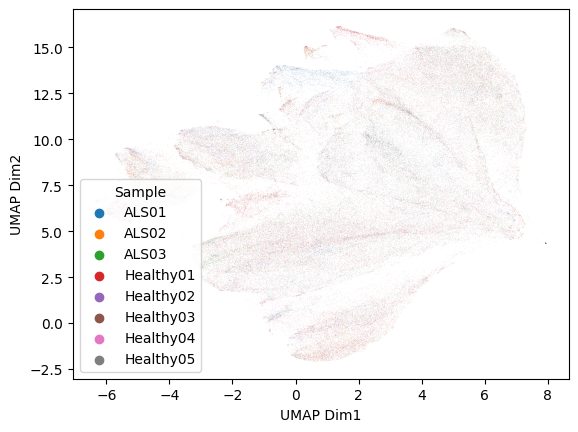

In [31]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(Xs_normalized)
res_df = ys.copy()
res_df["UMAP Dim1"] = embedding[:,0]
res_df["UMAP Dim2"] = embedding[:,1]
sns.scatterplot(res_df, x="UMAP Dim1", y="UMAP Dim2", hue="Sample", alpha=0.2, s=0.1)
plt.show()

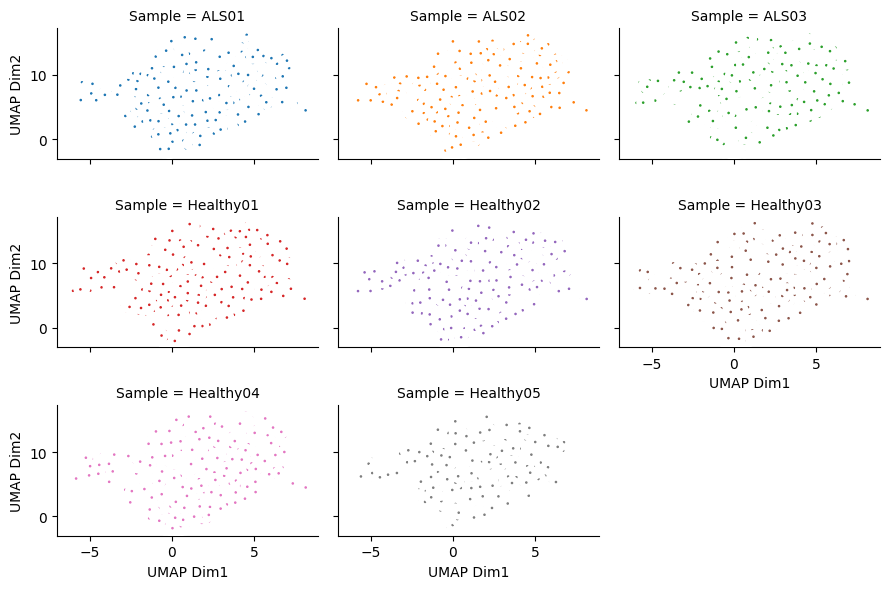

In [29]:
g = sns.relplot(
    data=res_df,
    x="UMAP Dim1", y="UMAP Dim2", hue="Sample", col="Sample",
    kind="scatter", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Reduce the frequency of the x axis ticks
g.tight_layout()
plt.show()

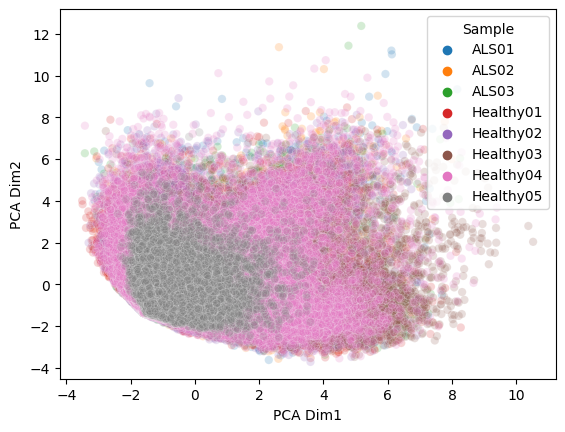

In [25]:
pca = PCA(2)
res = pca.fit_transform(Xs_normalized)
res_df = ys.copy()
res_df["PCA Dim1"] = res[:,0]
res_df["PCA Dim2"] = res[:,1]
sns.scatterplot(res_df, x="PCA Dim1", y="PCA Dim2", hue="Sample", alpha=0.2)
plt.show()

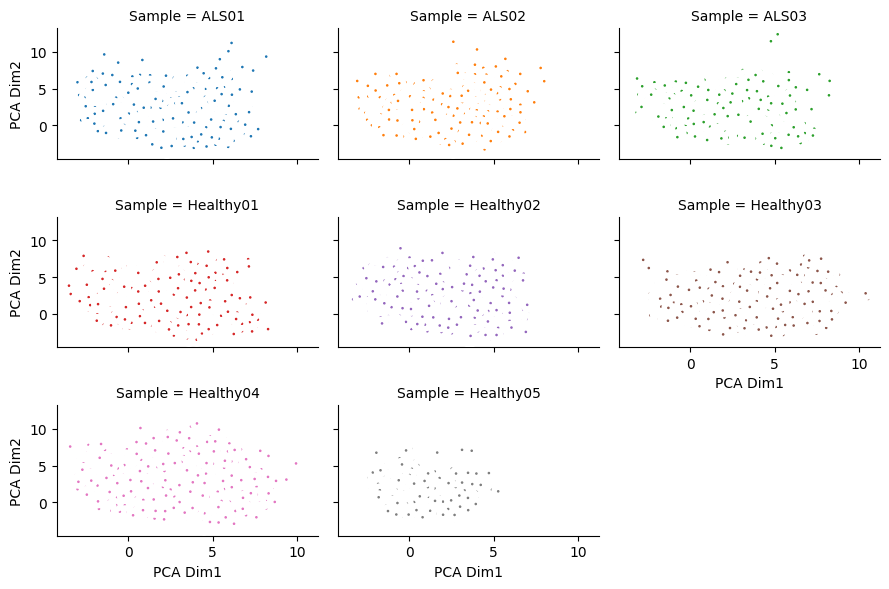

In [26]:
g = sns.relplot(
    data=res_df,
    x="PCA Dim1", y="PCA Dim2", hue="Sample", col="Sample",
    kind="scatter", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Reduce the frequency of the x axis ticks
g.tight_layout()
plt.show()

In [8]:
def conf_heatmap(res_df, props1, props2):
    hm = np.zeros((len(np.unique(res_df[props1])), len(np.unique(res_df[props2]))))

    for i, p1 in enumerate(np.unique(res_df[props1])):
        for j, p2 in enumerate(np.unique(res_df[props2])):
            sub_df = res_df[res_df[props1]==p1]
            sub_df = sub_df[sub_df[props2]==p2]
            hm[i,j] = len(sub_df)

    sns.heatmap(hm, annot=True, xticklabels=np.unique(res_df[props2]), yticklabels=np.unique(res_df[props1]), vmin=0, vmax=len(res_df))
    plt.tight_layout()
    plt.show()

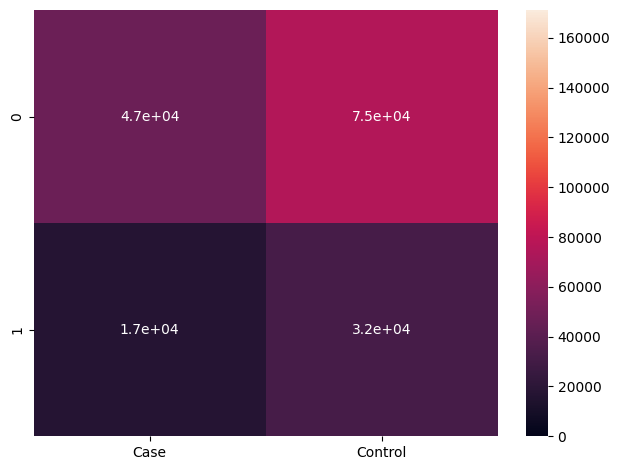

In [9]:
conf_heatmap(res_df, props1="2-Means Label", props2="Group")

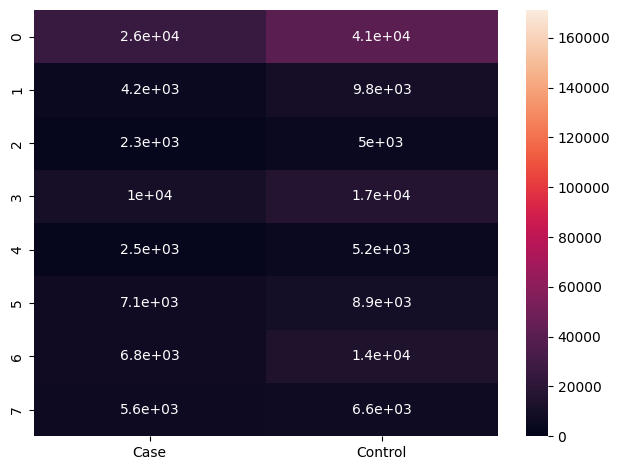

In [10]:
conf_heatmap(res_df, props1="8-Means Label", props2="Group")

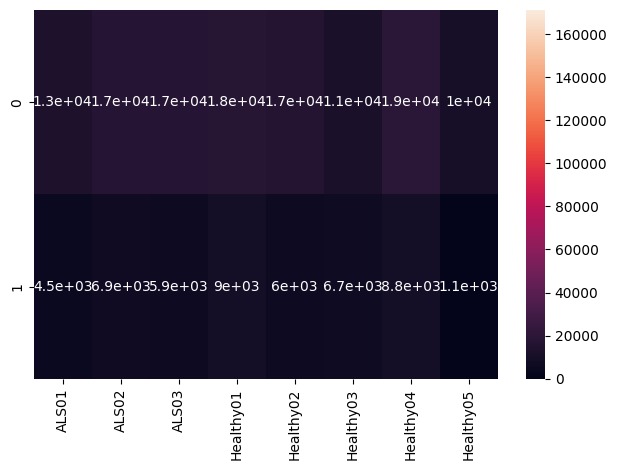

In [11]:
conf_heatmap(res_df, props1="2-Means Label", props2="Sample")

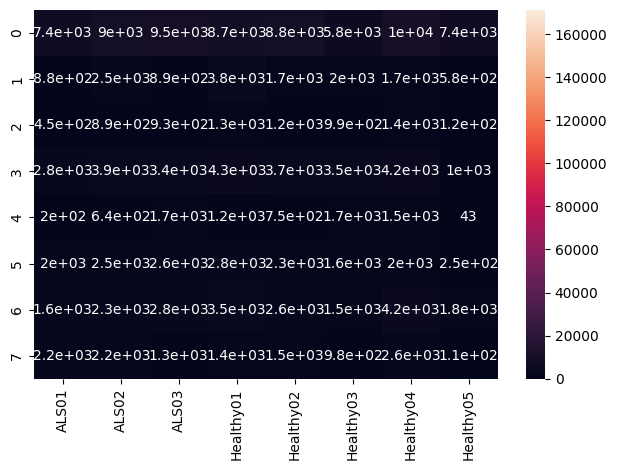

In [12]:
conf_heatmap(res_df, props1="8-Means Label", props2="Sample")